In [88]:
# Make all necessary imports for the project
import json
import nltk
nltk.download('stopwords')
import wordcloud
from matplotlib import pyplot as plt
from afinn import Afinn



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dayashrestha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Dataset Explanation:** The dataset we have gathered is in the form of json files. Each file has multiple json objects, so we read each file
as an array of all the json objects contained within that file.

In [3]:
# Read all relevant files and store contents in arrays of json objects
business_data = []
review_data = []
tip_data = []

with open('yelp_dataset/business.json', 'r') as bussiness_file:
    for line in bussiness_file:
        business_data.append(json.loads(line)) 
        
with open('yelp_dataset/review.json', 'r') as review_file:
    for line in review_file:
        review_data.append(json.loads(line))
        
with open ('yelp_dataset/tip.json', 'r') as tip_file:
    for line in tip_file:
        tip_data.append(json.loads(line))


**Initial look** The yelp dataset contains reviews of different types of businesses. First we look at where these businesses are located.

In [195]:
# Extract the latitude and longitude for all businesses to plot on a map
latitudes = []
longitudes = []
for each in business_data:
    latitudes.append(each['latitude'])
    longitudes.append(each['longitude'])

In [197]:
# Extract the list into a excel spreadsheet
import pandas as pd

cols = [latitudes, longitudes]
data = pd.DataFrame(columns=cols)
data.transpose()
data.to_excel('all.xlsx', sheet_name = 'New')

From the spreadsheet, we use an external mapping tool to plot our coordinates

**Now** that we know where these businesses are, we want to know what most of these businesses are

In [58]:
# Extract the categories of all the businesses and create a word cloud to see most popular business types reviewed on Yelp

def get_categories(business):
    cat = business['categories']
    if (type(cat) != None):
        if (type(cat) == str):
            return (cat.lower())
    
def get_all_categories(business_data):
    text_list = []
    for each in business_data:
        text_list.append(get_categories(each))
    text = ', '.join(map(str, text_list))
    return text

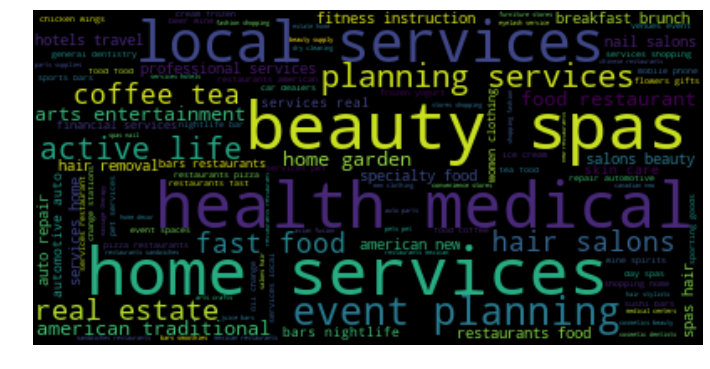

In [54]:
x = get_all_categories(business_data)

wc = wordcloud.WordCloud(max_font_size=40).generate(x)
plt.figure(figsize = (12,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**We now know** that not a lot of these businesses are restaurants. Based on the category field, we will determine all the restaurants and just extract those.

In [83]:
restaurants = []

keywords = [' restaurants', ' restaurant', ' food', ' diner', 'food', 'restaurants', 'restaurant', 'bar', ' bar', 'bars', ' bars']
for each in business_data:
    cat = get_categories(each)
    try:
        cat_list = cat.split(',')
        for k in keywords:
            if k in cat_list:
                restaurants.append(each)
                break
    except AttributeError:
        s = False
        

**Another look** We now look at where all the restaurants we have found are located.

In [199]:
# Extract the latitude and longitude for all restaurants to plot on a map
latitudes = []
longitudes = []
for each in restaurants:
    latitudes.append(each['latitude'])
    longitudes.append(each['longitude'])

cols = [latitudes, longitudes]
data = pd.DataFrame(columns=cols)
data.transpose()
data.to_excel('restaurant.xlsx', sheet_name = 'New')

**A look** at some of the common words under categories for restaurants

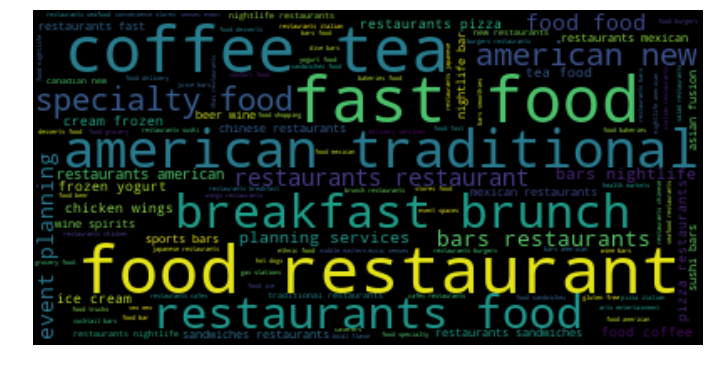

In [85]:
x = get_all_categories(restaurants)

wc = wordcloud.WordCloud(max_font_size=40).generate(x)
plt.figure(figsize = (12,9))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [108]:
# Get the business ids of these identified restaurants
def get_restaurant_ids(restaurants):
    business_ids = []
    for each in restaurants:
        business_ids.append(each['business_id'])
    return business_ids

**Proceed to** carrying out a sentiment analysis on the reviews and tips that these restaurants received on yelp

In [144]:
# Generate sentiment scores on the tips that reviewers shared about the restaurants
stopwords = nltk.corpus.stopwords.words("english")
def calculate_sentiment(data, restaurant_ids):
    afinn = Afinn()
    sentiment = []
    for each in data:
        if len(each['text']) < 30:
            continue
        if each['business_id'] in restaurant_ids:
            text = each['text']
            text = re.sub(r'[^\w\s]','',text) #remove punctuation
            try:
                words = text.split(' ')
                words = [w.lower() for w in words if w.lower() not in stopwords]
                text = ' '.join(words)
                try:
                    sentiment.append(afinn.score(text)/ len(words))
                except ZeroDivisionError:
                    sentiment.append(afinn.score(text))
            except AttributeError:
                sentiment.append(0)
    return sentiment

In [142]:
sentiment_tip = calculate_sentiment(tip_data, restaurant_ids)

In [159]:
def calculate_sentiment_average(data, restaurant_ids):
    afinn = Afinn()
    sentiment = []
    for each in data[::5]:
        if len(each['text']) < 30: 
            continue
        if each['business_id'] in restaurant_ids:
            text = each['text']
            text = re.sub(r'[^\w\s]','',text) #remove punctuation
            try:
                words = text.split(' ')
                words = [w.lower() for w in words if w.lower() not in stopwords]
                text = ' '.join(words)
                try:
                    sentiment.append(afinn.score(text)/ len(words))
                except ZeroDivisionError:
                    sentiment.append(afinn.score(text))
            except AttributeError:
                sentiment.append(0)
    return sentiment

In [161]:
sentiment_review= calculate_sentiment_average(review_data, restaurant_ids)

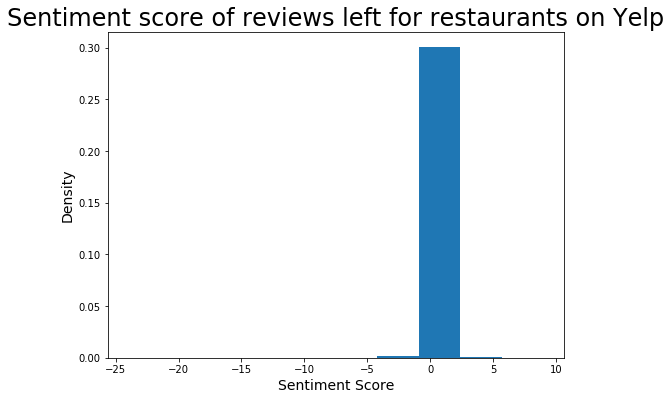

In [170]:
# Plotting the sentiment scores of the two categories

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.hist(sentiment_tip, density=True)
plt.title("Sentiment score of reviews left for restaurants on Yelp", fontsize=24)
plt.xlabel("Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

#plt.subplot(1,2,2)
#plt.hist(sentiment_review, color='forestgreen', density=True)
#plt.title("Sentiment score of the each review a restaurant received on Yelp", fontsize=14)
#plt.xlabel("Sentiment Score", fontsize=14)
#plt.ylabel("Density", fontsize=14)

plt.show()

In [173]:
# Extracting the average ratings
ratings = []
for each in restaurants:
    ratings.append(each['stars'])
    
import collections

ratings_dic = collections.Counter(ratings)
x_ratings = list(ratings_dic.keys())
y_count = list(ratings_dic.values())

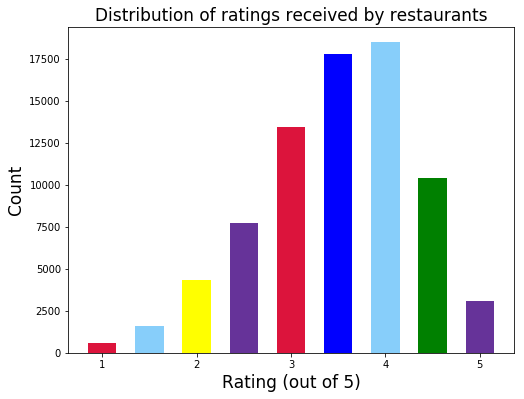

In [191]:
# Plotting a chart of the ratings

plt.figure(figsize=(8,6))
colors = ['rebeccapurple', 'lightskyblue', 'crimson', 'b', 'g', 'yellow' ]
plt.bar(x_ratings, y_count, color=colors, align='center', width=0.3)
plt.title("Distribution of ratings received by restaurants", fontsize=17)
plt.xlabel("Rating (out of 5)", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.show()

**Lastly, to answer our main question**, what are the top 10 most popular restaurants in the US based on Yelp reviews? <br>
Criteria: only considering restaurants with at least a 1000 reviews <br>
Based on: Highest average rating

In [117]:
popular = []
for each in restaurants:
    if each['review_count'] > 1000:
        features = [each['name'], each['state']]
        res = [each['stars'], features]
        popular.append(res)
popular.sort(key=lambda x: x[0], reverse=True)
popular_ten = popular[:10]

print ("The top 10 most popular restaurants in the US based on Yelp reviews are:")
for x in popular_ten:
    print ("Name: %s, Location: %s, Average Rating: %f" % (x[1][0], x[1][1], x[0]))

The top 10 most popular restaurants in the US based on Yelp reviews are:
Name: Little Miss BBQ, Location: AZ, Average Rating: 5.000000
Name: Brew Tea Bar, Location: NV, Average Rating: 5.000000
Name: Fountains of Bellagio, Location: NV, Average Rating: 4.500000
Name: Harumi Sushi, Location: AZ, Average Rating: 4.500000
Name: Juan's Flaming Fajitas & Cantina, Location: NV, Average Rating: 4.500000
Name: Defalco's Italian Grocery, Location: AZ, Average Rating: 4.500000
Name: Green New American Vegetarian, Location: AZ, Average Rating: 4.500000
Name: Pinball Hall Of Fame, Location: NV, Average Rating: 4.500000
Name: Yardbird Southern Table & Bar, Location: NV, Average Rating: 4.500000
Name: Baguette Cafe, Location: NV, Average Rating: 4.500000
